In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score , auc
from sklearn.ensemble import RandomForestClassifier

In [452]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [453]:
train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [454]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [455]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [456]:
train.columns
train = train.drop(columns=['id'])

EDA

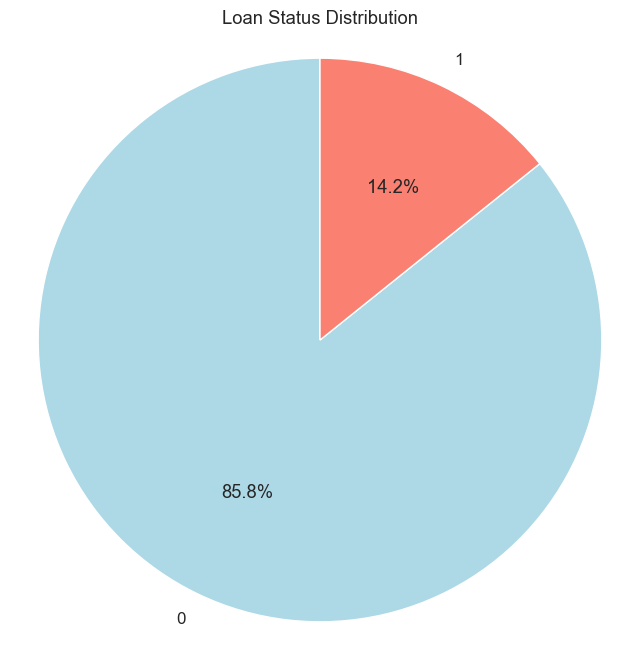

In [457]:

loan_status_counts = train['loan_status'].value_counts()
    

plt.figure(figsize=(8, 8))

plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Loan Status Distribution')
plt.axis('equal')  
plt.plot()
plt.show()

In [458]:
def plot_numeric(df):
    for col in df._get_numeric_data().columns:
        if col == 'loan_status':
            continue  
        else:

            df_group = df[['loan_status', col]].copy()
            df_group['bin_' + col] = pd.qcut(df_group[col].astype(float), q=6, duplicates='drop', precision=0)
            df_group = df_group.groupby('bin_' + col).agg({'loan_status': ['count', 'sum']})
            df_group.columns = df_group.columns.map('_'.join)
            df_group['dist'] = df_group['loan_status_count'] / df_group['loan_status_count'].sum()
            df_group['notapprove'] = df_group['loan_status_sum'] / df_group['loan_status_count']
            df_group = df_group.reset_index()
            x1 = df_group['bin_' + col].astype(str)
            y1 = df_group['dist'] * 100
            y2 = df_group['notapprove'] * 100


            sns.set(font_scale=1.1)
            sns.set_style("whitegrid")
            fig, ax = plt.subplots(figsize=(9, 5))
            plt.tick_params(axis='x', rotation=45)

            # % Distribution
            ax.bar(x1, y1, color='lightsteelblue', alpha=0.6)

            # % Bad Rate
            ax2 = ax.twinx()
            sns.lineplot(data=df_group, x=x1, y=y2, marker='o', markerfacecolor='red', markersize=6,
                         color='orange', linewidth=2, ax=ax2, label='% not approve')

            ax.set_xlabel(col)
            ax.set_ylabel('% Distribution')
            ax2.set_ylabel('% Not Approve')
            ax.grid(False)
            ax2.grid(False)

            # % Bad Rate on Graph
            for x, y in zip(df_group.index, df_group['notapprove'] * 100):
                label = "{:.2f}".format(y)
                plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

            plt.title(f'Distribution and Not Approve rate for {col}')
            plt.show()

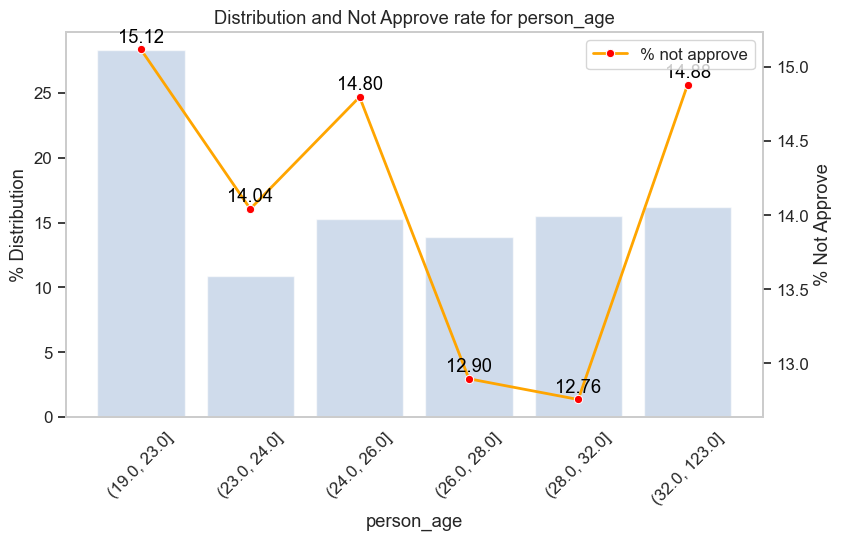

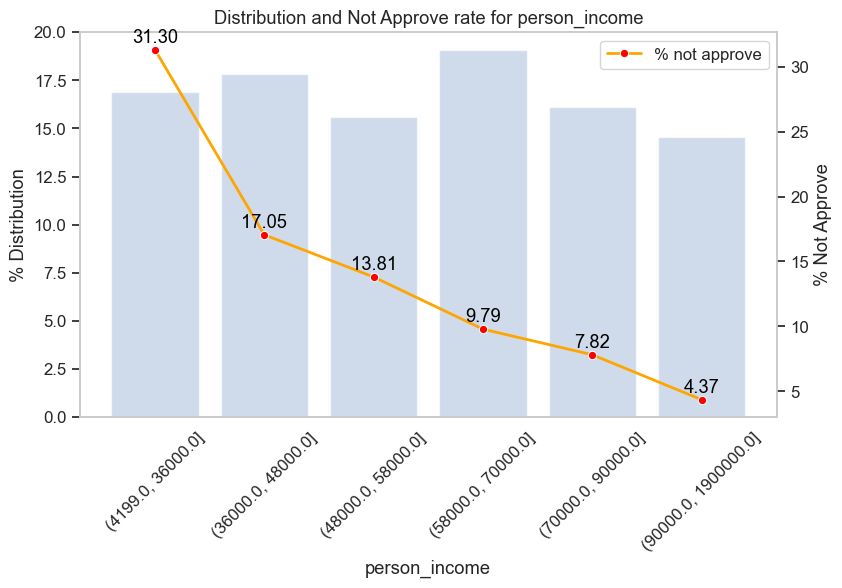

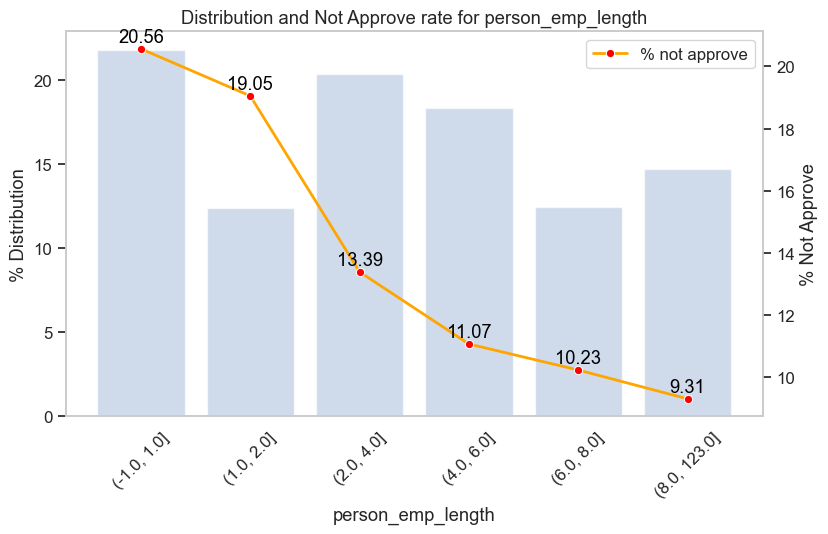

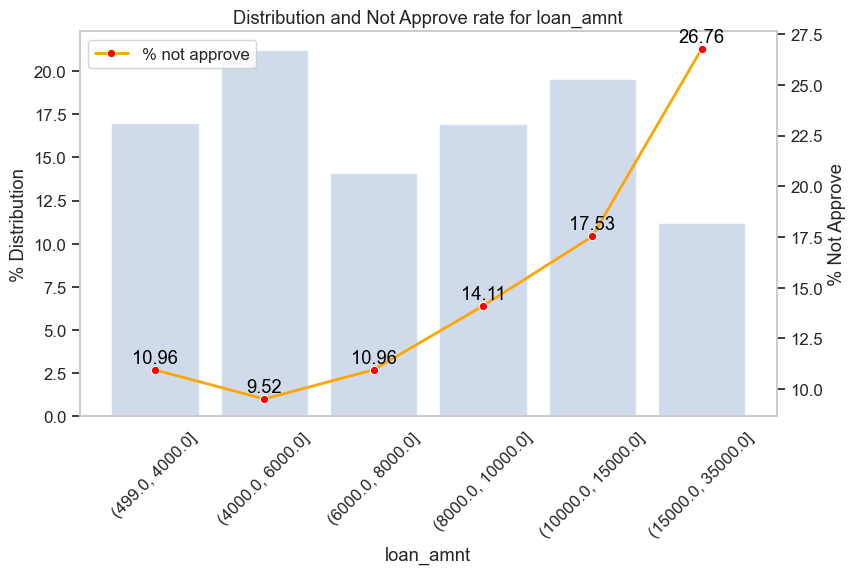

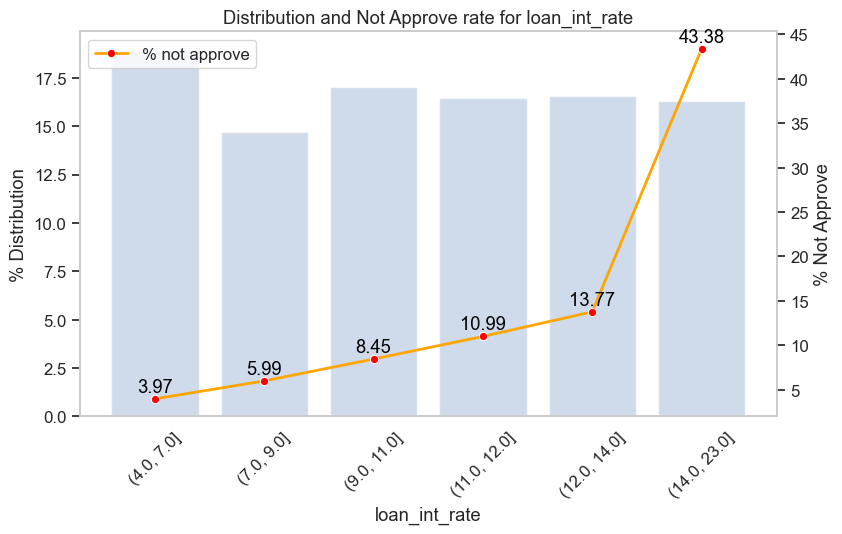

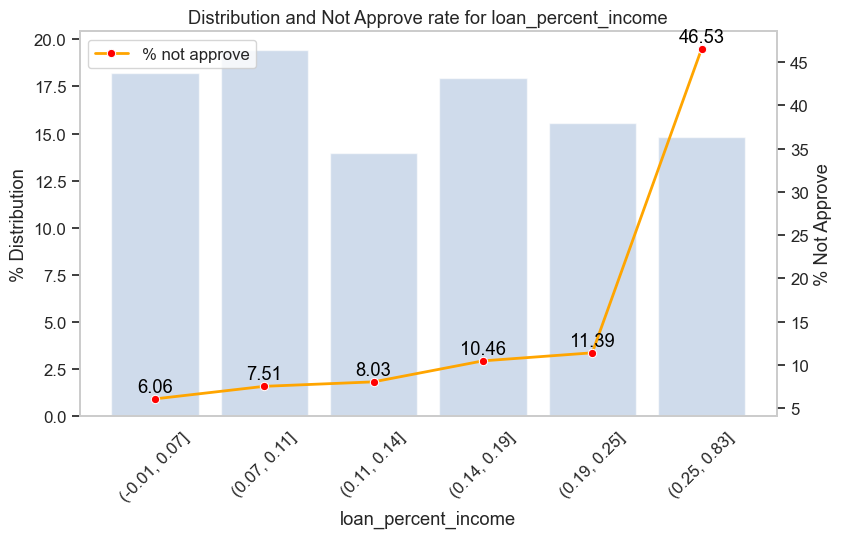

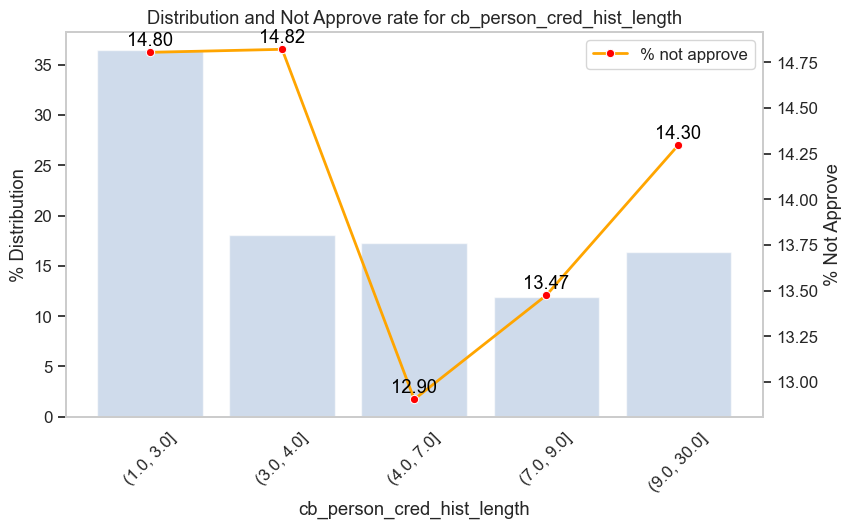

In [459]:
plot_numeric(train)

In [460]:
def plot_categorcial(df):
    for col in df.select_dtypes(exclude=['number']).columns:
        if col == 'loan_status':
            continue  
        
        # สร้าง DataFrame สำหรับการวิเคราะห์
        temp_df = pd.Series(df[col].value_counts() / len(df)).reset_index()
        temp_df.columns = [col, '%Dist']

        # คำนวณ Bad Rate
        temp_df = temp_df.merge(df.groupby([col])['loan_status'].mean().reset_index(),
                                on=col,
                                how='left').sort_values(by='loan_status').reset_index(drop=True)
        
        # สร้างกราฟ
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.xticks(temp_df.index, temp_df[col], rotation=45)
        ax2 = ax.twinx()
        ax.bar(temp_df.index, temp_df["%Dist"] * 100, color='lightsteelblue', alpha=0.6)

        # สร้างกราฟเส้นสำหรับ Bad Rate
        ax2.plot(temp_df.index, temp_df["loan_status"] * 100, color='orange', label='Bad Rate',
                 marker='o', markerfacecolor='red', linewidth=2)
        
        # ตั้งค่าต่าง ๆ ของกราฟ
        ax.set_ylabel('% Distribution')
        ax.set_xlabel(col)
        ax2.set_ylabel('% Not Approve')
        ax.grid(False)
        ax2.grid(False)
        
        # แสดง % Bad Rate บนกราฟ
        for x, y in zip(temp_df.index, temp_df["loan_status"] * 100):
            label = "{:.2f}".format(y)
            plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black') 
        
        # แสดงกราฟ
        plt.title(f'Distribution and Not approve for {col}')
        plt.show()


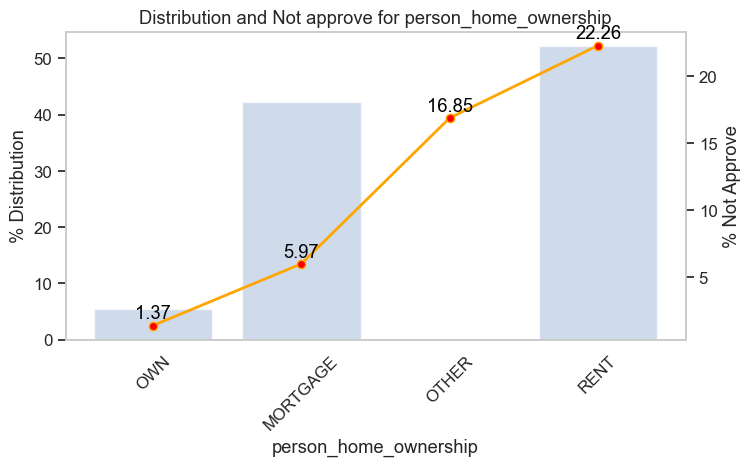

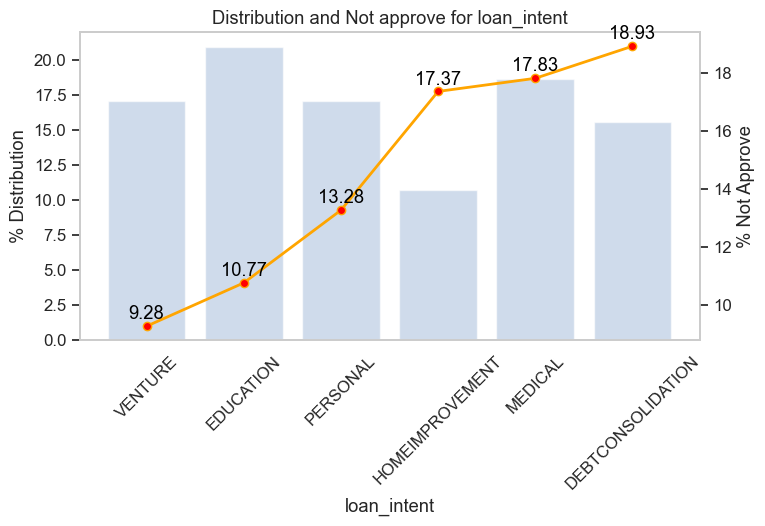

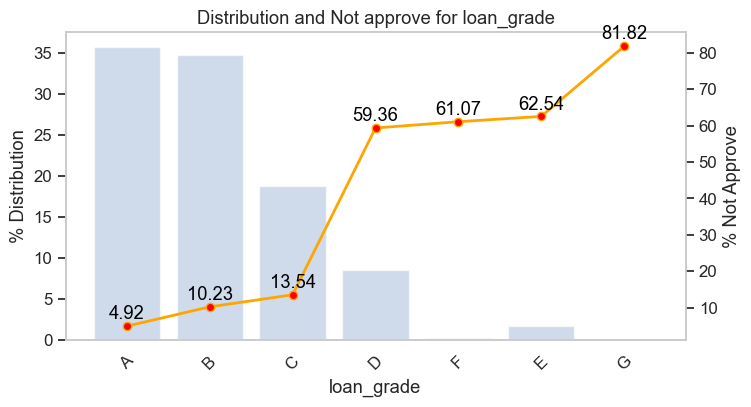

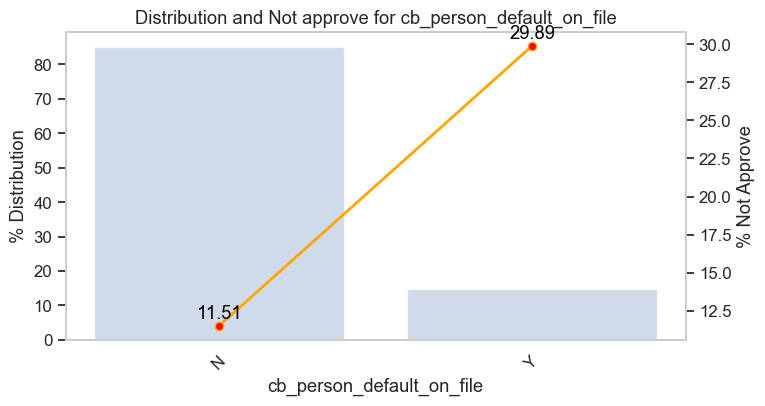

In [461]:
plot_categorcial(train)

In [462]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

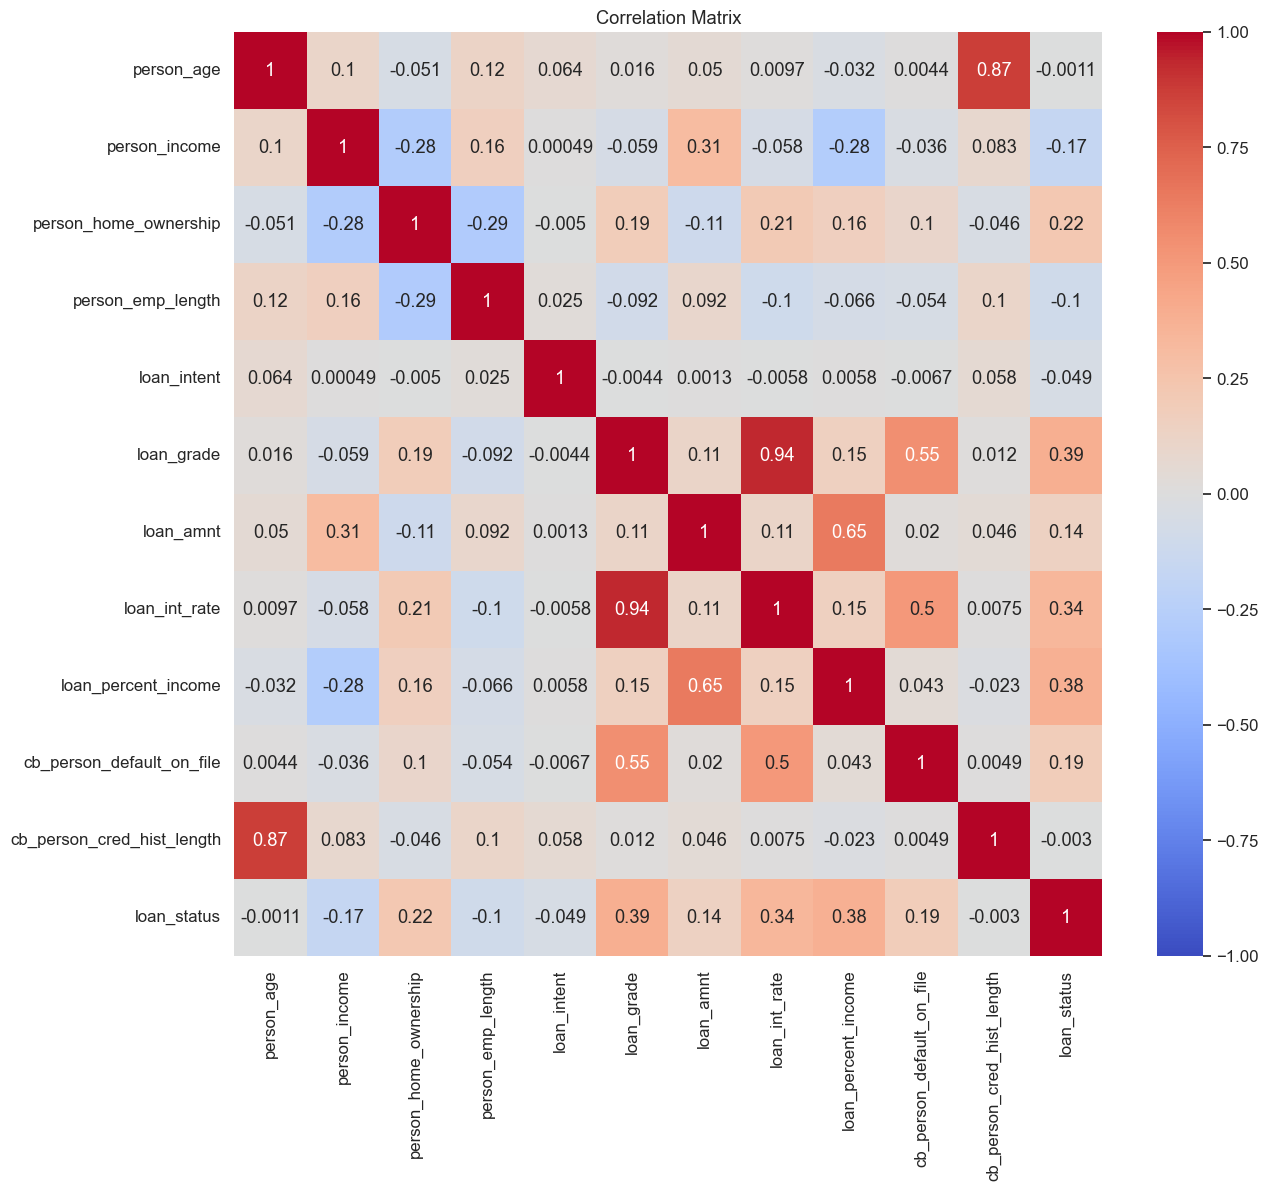

In [463]:
correlation_matrix = train.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Featureing Engineer

In [464]:
train['loan_to_income_ratio'] = train['loan_amnt'] / train['person_income']

Model

In [465]:
X = train.drop(['loan_status'], axis=1)
y = train['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_to_income_ratio
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0.171429
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0.071429
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0.208333
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0.171429
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,0,5.0,1,3,25000,15.95,0.21,1,10,0.208333
58641,28,28800,3,0.0,3,2,10000,12.73,0.35,0,8,0.347222
58642,23,44000,3,7.0,1,3,6800,16.00,0.15,0,2,0.154545
58643,22,30000,3,2.0,1,0,5000,8.90,0.17,0,3,0.166667


In [466]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.9525
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.74      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



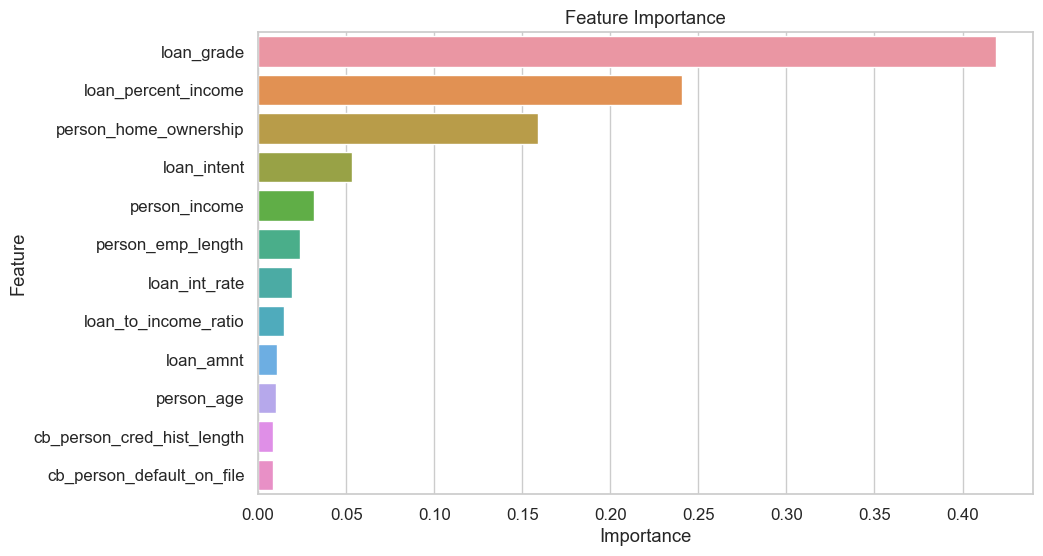

In [467]:
feature_importance = model.feature_importances_

# สร้าง DataFrame สำหรับความสำคัญของฟีเจอร์
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# แสดงกราฟความสำคัญของฟีเจอร์
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [468]:
def plot_roc_curve(y_true, y_scores):

    # คำนวณค่า FPR, TPR และ thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # คำนวณค่า AUC
    roc_auc = auc(fpr, tpr)

    # วาดกราฟ ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')  # เส้นทแยงมุม
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

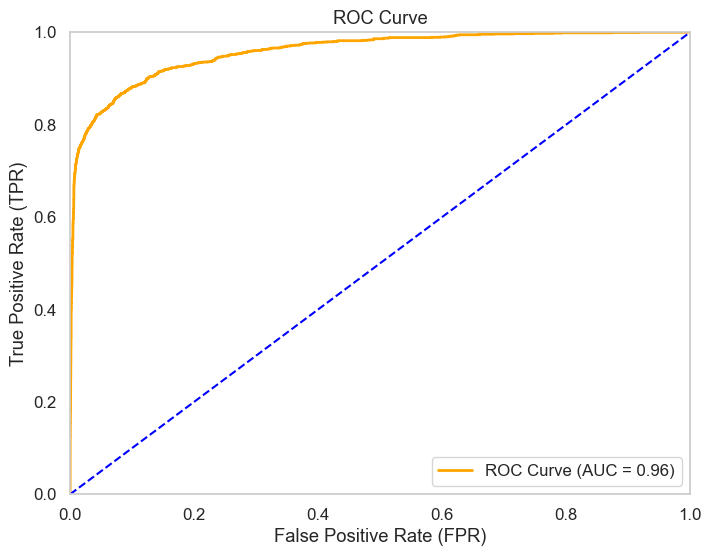

In [469]:
plot_roc_curve(y_test , y_proba)

In [470]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [471]:
y_pred1 = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred1))

Accuracy: 0.9488
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10087
           1       0.91      0.70      0.79      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.88     11729
weighted avg       0.95      0.95      0.95     11729



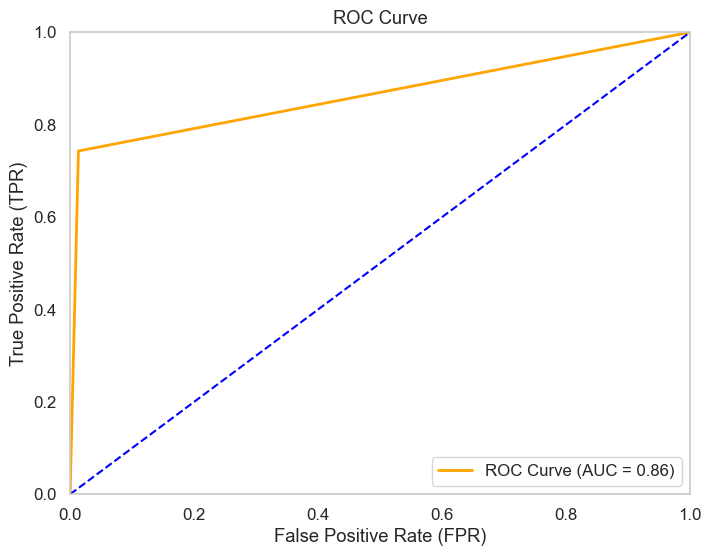

In [472]:
plot_roc_curve(y_test , y_pred)